In [1]:
# Noteook to generate the library for the design space and train embeddings.

# Author : Shikhar Tuli

from library import GraphLib, Graph

# Create an empty graph library with the hyper-parameter ranges
# given in design_space.yaml
graphlib = GraphLib('../dataset/design_space_small.yaml')
print(graphlib)

Graph Library with design space:
{'hidden_size': [128, 256], 'attention_heads': [2, 4], 'encoder_layers': [2, 4], 'feed-forward_hidden': [1024, 2048, 4096], 'similarity_metric': ['sdp', 'wma']}
Number of graphs: 0


In [2]:
# Generating graph library
graphlib.build_library(check_isomorphism=False)

Creating Graph library


Generating transformers with 2 encoder layers:   0%|          | 0/162 [00:00<?, ?it/s]

Generating transformers with 4 encoder layers:   0%|          | 0/1875 [00:00<?, ?it/s]

Graph library created! 
2037 graphs within the design space.


In [3]:
# Simple test to check isomorphisms, rather than comparing hash for every new graph

hashes = [graph.hash for graph in graphlib.library]
print(f'No two graphs have same hash: {len(hashes) == len(set(hashes))}')

No two graphs have same hash: True


In [16]:
# Check Graph object for first transformer in the library

graphlib.library[0].graph

(array([[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 ['input',
  'a_h128_s-sdp',
  'a_h128_s-sdp',
  'add_norm',
  'f1024',
  'add_norm',
  'a_h128_s-sdp',
  'a_h128_s-sdp',
  'add_norm',
  'f1024',
  'add_norm',
  'output'])

In [3]:
# Generate naive embeddings

graphlib.build_naive_embeddings()

Building embeddings for the Graph library
Embeddings generated, of size: 17


In [4]:
# Observe naive embeddings (zscored)

graphlib.library[0].embedding

array([-0.40962329, -0.40962329, -0.40962329, -0.41574244, -0.41574244,
       -0.02411666, -0.02411666, -0.41574244, -0.41574244,  2.71726381,
        2.71726381, -0.41574244, -0.41574244, -0.41574244, -0.41574244,
       -0.41574244, -0.41574244])

Text(0.5, 1.0, 'Dissimilarity Matrix')

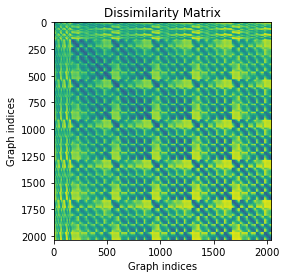

In [11]:
# Generate dissimilarity matrix based on kernel

import graph_util
from matplotlib import pyplot as plt
import numpy as np

graph_list = [graphlib.library[i].graph for i in range(len(graphlib))]

diss_mat = graph_util.generate_dissimilarity_matrix(graph_list)

plt.imshow(diss_mat)
plt.xlabel('Graph indices')
plt.ylabel('Graph indices')
plt.title('Dissimilarity Matrix')

In [ ]:
# Generate embeddings from dissimilarity matrix

embeddings = graph_util.generate_embeddings(diss_mat, 128)

print(f'Shape of embeddings (numer of graphs, embedding size): {embeddings.shape}')

Text(0.5, 1.0, 'Embeddings Distance Matrix')

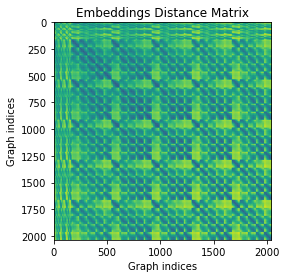

In [22]:
# Generate distance matrix from embeddings

from sklearn.metrics import pairwise_distances

embedding_diss_mat = pairwise_distances(embeddings, embeddings, metric='euclidean')

plt.imshow(embedding_diss_mat)
plt.xlabel('Graph indices')
plt.ylabel('Graph indices')
plt.title('Embeddings Distance Matrix')

In [23]:
# Print Frobenius norm of difference between two distance matrices

print(np.linalg.norm(embedding_diss_mat - diss_mat))

74.17969384311962


Text(0.5, 1.0, 'Distance prediction error (Forb. norm) with embedding size')

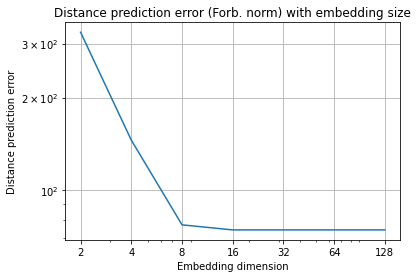

In [38]:
# Plot Frobebius norm of difference for different embedding sizes

from tqdm import tqdm

diss_mat = graph_util.generate_dissimilarity_matrix(graph_list)
fro_dist = []

embedding_sizes = tqdm([2, 4, 8, 16, 32, 64, 128])
for embedding_size in embedding_sizes:
    embedding_sizes.set_description(f'Processing embedding dimension: {embedding_size}')
    embeddings = graph_util.generate_embeddings(diss_mat, embedding_size)
    embedding_diss_mat = pairwise_distances(embeddings, embeddings, metric='euclidean')
    fro_dist.append(np.linalg.norm(embedding_diss_mat - diss_mat))
    
plt.loglog([2, 4, 8, 16, 32, 64, 128], fro_dist)
plt.xticks([2, 4, 8, 16, 32, 64, 128], ['2', '4', '8', '16', '32', '64', '128'])
plt.yticks([100, 200, 300])
plt.grid()
plt.xlabel('Embedding dimension')
plt.ylabel('Distance prediction error')
plt.title('Distance prediction error (Forb. norm) with embedding size')

In [4]:
# Build embeddings for GraphLib object based on above tests

graphlib.build_embeddings(8, kernel='WeisfeilerLehman')

In [7]:
# Observe embeddings

graphlib.library[0].embedding

array([-0.17173251, -0.10140808, -0.00720463, -0.14938796,  0.16885945,
       -0.37085198, -0.1324836 , -0.09012889])

In [9]:
# Plot t-SNE for generated (naive) embeddings

import graph_util
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd

embeddings = graph_util.generate_sparse_embeddings([graph.model_dict for graph in graphlib.library], graphlib.design_space)

two_dim = TSNE(n_components=2, learning_rate=20, perplexity=50).fit_transform(embeddings)

tsne_df = pd.DataFrame(data={'t-SNE 1': two_dim[:, 0], 't-SNE 2': two_dim[:, 1], 
                             'model_dicts': [f'{graph.model_dict}' for graph in graphlib.library],
                              'layers': [graph.model_dict['l'] for graph in graphlib.library]})

fig = px.scatter(tsne_df, x='t-SNE 1', y='t-SNE 2', hover_data=['model_dicts'])
fig.show()

In [12]:
# Plot t-SNE for generated (MDS-based) embeddings

import graph_util
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd

embeddings = graph_util.generate_embeddings(diss_mat, 8)

two_dim = TSNE(n_components=2, learning_rate=20, perplexity=50).fit_transform(embeddings)

tsne_df = pd.DataFrame(data={'t-SNE 1': two_dim[:, 0], 't-SNE 2': two_dim[:, 1], 
                             'model_dicts': [f'{graph.model_dict}' for graph in graphlib.library],
                              'layers': [graph.model_dict['l'] for graph in graphlib.library]})

fig = px.scatter(tsne_df, x='t-SNE 1', y='t-SNE 2', hover_data=['model_dicts'])
fig.show()